In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
data = pd.read_csv('./healthcare-dataset-stroke-data.csv')

- Data Cleaning and EDA -- plotting each feature against target 

- Models to try -- xgboost, random forest, shallow neural net, logist reg, knn

In this dataset, we encounter imbalanced data with only 5% of the data being positive for stroke. We will try different methods to counteract this problem.

Before we begin, let's understand why this is a problem in the first place. When we work with machine learning algorithm, the model learns over time coursing through the data. It looks at the data and starts to find patterns and distinguishes between them to make predictions. We track a model's effectiveness from the accuracy of the predictions. Now, if only 5% of the data is positive, the model can learn to start predicting negative values in all cases. Thus, while the model has a 95% accuracy, it cannot catch a patient having a stroke.

We need to b able to distinguish between the false negative (when the model should predict stroke but does not) and true negative values. It is okay if the models has a few false positive values (determining stroke when the patient doesn't have one) but false negative values should be avoided completely.

In [3]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


From the data above, there are a few things to note - hypertension, heart_disease and stroke are categorical variables. We will need to analyse those separately.

### Possible Outliers:
- There seems to be something wrong with the age column since we have a value of 0.08. 
- The BMI values should not have values of 10
- Similarly, glucose levels of 55 and 270 are concerning and might need to be adjusted.
We will look at these more closely soon.


# Plan Going Forward

- Look at the outliers and why some of the values are abnormal.
- Look at the bmi levels in the data for all 'work types' and plot against stroke variable.
- Check for correlation between variables and multicollinearity
- Create categories for underweight and obese using bmi. Also diabetic categories for glucose levels
- Analyse relation between hypyertension, heart disease as compared to stroke detection and their frequency in different work types.

# Data Cleaning

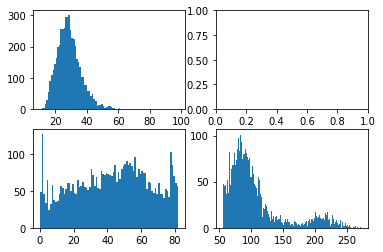

In [35]:
# Start by checking if age, bmi and glucose are guassian or parametric.

fig, ax = plt.subplots(2,2)
ax[0,0].hist(data['bmi'], bins=np.arange(data['bmi'].min(), data['bmi'].max()+1))
ax[1,0].hist(data['age'], bins=np.arange(data['age'].min(), data['age'].max()+1))
ax[1,1].hist(data['avg_glucose_level'], bins=np.arange(data['avg_glucose_level'].min(), data['avg_glucose_level'].max()+1))
plt.show()

In [51]:
# BMI and Glucose Levels seem to resemble Normal Distribution so we will use Z-Score to find outliers. 
# However, for Age, we will use IQR.


def outlier_detection(data, category):
    mean = np.mean(data[category])
    sd = np.std(data[category])
    threshold = 2
    outliers = []
    for k, i in enumerate(data[category]): 
        z = (i-mean)/sd 
        if abs(z) > threshold: 
            outliers.append(k) 
    return data.drop(data.index[outliers])

data = outlier_detection(data, 'bmi')
data = outlier_detection(data, 'avg_glucose_level')

print(data['stroke'].value_counts())
print('--------------------------------')
print(data.shape)


0    3645
1     144
Name: stroke, dtype: int64
--------------------------------
(3789, 11)


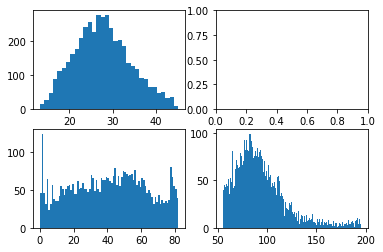

In [42]:
# Visualising the data now:
fig, ax = plt.subplots(2,2)
ax[0,0].hist(data['bmi'], bins=np.arange(data['bmi'].min(), data['bmi'].max()+1))
ax[1,0].hist(data['age'], bins=np.arange(data['age'].min(), data['age'].max()+1))
ax[1,1].hist(data['avg_glucose_level'], bins=np.arange(data['avg_glucose_level'].min(), data['avg_glucose_level'].max()+1))
plt.show()


In [58]:
# Now, let's move on to the age. Firstly, the age at 0 have an abnormally high number of entries. 
# Moreover, the ages are in decimal. We need to clean these values as well

display(data[data['work_type'] == 'children'].describe())
display(data[data['age'] < 3].describe())

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,579.000000,579.0,579.000000,579.000000,567.000000,579.000000
mean,6.900518,0.0,0.001727,88.730984,20.423280,0.003454
std,4.506396,0.0,0.041559,18.696117,4.106066,0.058722
min,0.080000,0.0,0.000000,55.350000,15.500000,0.000000
25%,3.000000,0.0,0.000000,74.510000,17.600000,0.000000
50%,7.000000,0.0,0.000000,87.740000,19.300000,0.000000
75%,11.000000,0.0,0.000000,102.630000,21.900000,0.000000
max,16.000000,0.0,1.000000,129.660000,38.700000,1.000000


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,142.000000,142.0,142.000000,142.000000,137.000000,142.000000
mean,1.439437,0.0,0.007042,88.692465,19.372993,0.007042
std,0.576750,0.0,0.083918,20.574748,2.755169,0.083918
min,0.080000,0.0,0.000000,55.510000,15.500000,0.000000
25%,1.080000,0.0,0.000000,72.112500,17.500000,0.000000
50%,1.600000,0.0,0.000000,87.425000,18.900000,0.000000
75%,2.000000,0.0,0.000000,107.627500,20.400000,0.000000
max,2.000000,0.0,1.000000,129.070000,33.100000,1.000000


Looking closer at the data, we find that there are over 140 entries with children aged below 3 and this was also the reason for our extremely low BMI values. The values in decimals are the months of the children who are less than 1 year old. Thus, we won't be changing anything in this column

# Data Exploration

Now, we can start creating new variables and define bmi and glucose levels as categories instead which will make it easy for the model to read.
Also, let's take a look at some possible correlations that could exist.

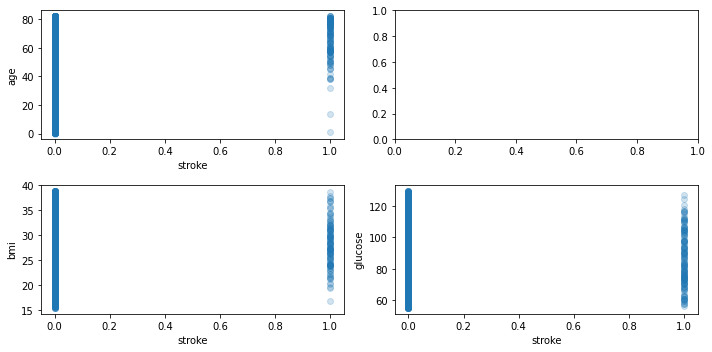

In [60]:
# Here we'll do some EDA to get a clearer picture of the data we're dealing with and some insights into possible patterns that exist.

fig, ax = plt.subplots(2,2, figsize=(10,5))

ax[0,0].scatter(data['stroke'], data['age'], alpha=0.2)
ax[0,0].set_xlabel('stroke')
ax[0,0].set_ylabel('age')

ax[1,1].scatter(data['stroke'], data['avg_glucose_level'], alpha=0.2)
ax[1,1].set_xlabel('stroke')
ax[1,1].set_ylabel('glucose')

ax[1,0].scatter(data['stroke'], data['bmi'], alpha=0.2)
ax[1,0].set_xlabel('stroke')
ax[1,0].set_ylabel('bmi')

fig.tight_layout()


# We see strokes tend to be common amongst people above the age of 50, with a bmi between 20 and 45, and with extreme glucose levels (low or high).

In [8]:
data.drop(['id'], inplace=True, axis=1)